In [1]:
# train_recommender.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib     # better for sklearn objects than pickle
import os

Matplotlib is building the font cache; this may take a moment.


In [3]:
# --- Settings ---
DATA_PATH = "../data/books.csv"   # adjust if running from root or notebook/
OUTPUT_MODEL = "../model/recommender.pkl"

# --- Load data ---
df = pd.read_csv(DATA_PATH, on_bad_lines='skip', low_memory=False)
  # avoid deprecated error_bad_lines
print("Loaded", df.shape, "rows")

Loaded (11123, 12) rows


In [4]:
# --- Basic cleaning & rename columns with stripped whitespace ---
df.columns = [c.strip() for c in df.columns]
# Fix columns like '  num_pages' -> 'num_pages'
df.columns = [c.replace("  ", " ").strip() for c in df.columns]

# Keep only relevant columns and drop rows with missing important fields
keep_cols = ['title', 'authors', 'average_rating', 'ratings_count', 'language_code', 'num_pages']
for col in keep_cols:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")
df2 = df[keep_cols].copy()
df2 = df2.dropna(subset=['title', 'average_rating', 'ratings_count'])
df2['average_rating'] = pd.to_numeric(df2['average_rating'], errors='coerce')
df2['ratings_count'] = pd.to_numeric(df2['ratings_count'], errors='coerce').fillna(0)
df2['num_pages'] = pd.to_numeric(df2['num_pages'], errors='coerce').fillna(df2['num_pages'].median())
df2 = df2.reset_index(drop=True)
print("After cleaning:", df2.shape)

After cleaning: (11123, 6)


In [5]:
# --- EDA snippets (optional display) ---
# Top authors
top_authors = df2['authors'].value_counts().head(10)
print(top_authors)

authors
Stephen King        40
P.G. Wodehouse      40
Rumiko Takahashi    39
Orson Scott Card    35
Agatha Christie     33
Piers Anthony       30
Sandra Brown        29
Mercedes Lackey     29
Dick Francis        28
Terry Pratchett     23
Name: count, dtype: int64


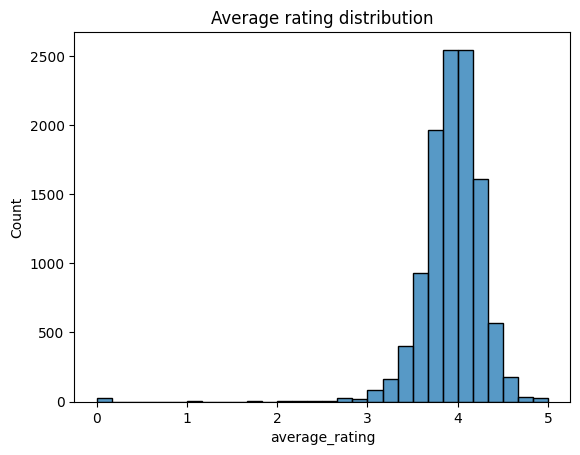

In [6]:
# Rating distribution plot (optional)
sns.histplot(df2['average_rating'].dropna(), bins=30)
plt.title('Average rating distribution')
plt.show()

In [7]:
# --- Feature engineering for recommendations ---
# Bucket average_rating
def rating_bucket(x):
    if x <= 1: return '0-1'
    if x <= 2: return '1-2'
    if x <= 3: return '2-3'
    if x <= 4: return '3-4'
    return '4-5'

df2['rating_bucket'] = df2['average_rating'].apply(rating_bucket)

# One-hot encode rating bucket and language
rating_df = pd.get_dummies(df2['rating_bucket'])
language_df = pd.get_dummies(df2['language_code'].fillna('unknown'))

In [8]:
# Build feature matrix
features_df = pd.concat([
    rating_df,
    language_df,
    df2[['average_rating', 'ratings_count', 'num_pages']].reset_index(drop=True)
], axis=1)

# scale features
scaler = MinMaxScaler()
features = scaler.fit_transform(features_df)


In [9]:
# --- Fit NearestNeighbors model ---
n_neighbors = 6  # 5 recommendations + itself
model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='euclidean')
model.fit(features)
distances, indices = model.kneighbors(features)  # for sanity/check

# --- Prepare supporting metadata to save ---
# We'll save: model, scaler, features_df columns, dataframe (df2), and title->index map
title_to_index = pd.Series(df2.index, index=df2['title']).to_dict()

payload = {
    'model': model,
    'scaler': scaler,
    'features_columns': list(features_df.columns),
    'df': df2,  # small-ish dataframe containing metadata (title, authors, etc.)
    'title_to_index': title_to_index
}

os.makedirs(os.path.dirname(OUTPUT_MODEL), exist_ok=True)
joblib.dump(payload, OUTPUT_MODEL)
print("Saved recommender to", OUTPUT_MODEL)


Saved recommender to ../model/recommender.pkl


In [10]:
# Example test
def recommend(title, n=5):
    if title not in payload['title_to_index']:
        return []
    idx = payload['title_to_index'][title]
    neighs = payload['model'].kneighbors(scaler.transform(features_df), n_neighbors=n+1, return_distance=False)
    # The above line recomputes neighbors; simpler is to use precomputed indices but this is fine
    rec_ids = neighs[idx]
    rec_titles = [payload['df'].loc[i, 'title'] for i in rec_ids if i != idx]
    return rec_titles[:n]

print("Recommendations for a sample book:", recommend(df2.loc[0, 'title']))

Recommendations for a sample book: ['Dostoevsky: The Mantle of the Prophet  1871-1881', 'The Complete C.S. Lewis Signature Classics', 'Novels 1901–1902: The Sacred Fount / The Wings of the Dove', 'Fire in the Minds of Men: Origins of the Revolutionary Faith', 'Collected Essays: Notes of a Native Son / Nobody Knows My Name / The Fire Next Time / No Name in the Street / The Devil Finds Work / Other Essays']
